<a href="https://colab.research.google.com/github/lee-messi/machine-learning/blob/main/amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text --quiet
!pip install tensorflow_hub --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.3 MB/s eta 0:00:00


## Import Packages and Dataset

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

Here, we are going to work on a binary classifier where we try and predict the star reviews of Amazon Beauty products based on their overall ratings. The dataset is part of the 2018 Amazon review data and can be found [here](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/).

In [5]:
reviews = pd.read_json('drive/MyDrive/Colab Notebooks/All_Beauty.json', lines = True)
print(reviews.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')


## Preprocessing

We are going to perform the following preprocessing steps on the Amazon review data:
+ We are going to retain two columns - the review text (**reviewText**) and the overall rating (**overall**).
+ As this is a binary classifier problem, we are going to map the overall rating column as a binary one (1 if the rating is greater than or equal to 4 and 0 otherwise).
+ We are going to remove any observations that have N/A values.

In [8]:
reviews = reviews[['reviewText', 'overall']]
reviews['labels'] = (reviews.overall >= 4).astype(int)
reviews = reviews.dropna()

To prevent the model from being biased, we are going to create a new dataset that is balanced with respect to the labels. First, let's inspect how unbalanced our labels are:

In [6]:
reviews_balanced = reviews.groupby('overall').sample(500)
reviews_balanced.value_counts('overall')

overall
1    500
2    500
3    500
4    500
5    500
dtype: int64

In [42]:
train, val, test = np.split(reviews_balanced.sample(frac = 1),
                            [int(0.8 * len(reviews_balanced)), int(0.9 * len(reviews_balanced))])

In [46]:
def df_to_dataset(dataframe, shuffle = True, batch_size = 32):
  df = dataframe.copy()
  label = df.labels
  df = df.reviewText
  ds = tf.data.Dataset.from_tensor_slices((df, label))
  if shuffle == True:
    ds = ds.shuffle(buffer_size = len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return(ds)

In [47]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)

In [32]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [33]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.88845694, ..., -0.74748826,
        -0.7531471 ,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444669 , ..., -0.85847515,
        -0.71745366,  0.8808298 ]], dtype=float32)>

## Define First Model

In [48]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, trainable = True)

In [49]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [50]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [51]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 10)

Epoch 1/10
63/63 [==============================] - 84s 1s/step - loss: 0.6622 - accuracy: 0.6130 - val_loss: 0.6388 - val_accuracy: 0.6560
Epoch 2/10
63/63 [==============================] - 85s 1s/step - loss: 0.5977 - accuracy: 0.7055 - val_loss: 0.6076 - val_accuracy: 0.6840
Epoch 3/10
63/63 [==============================] - 81s 1s/step - loss: 0.5289 - accuracy: 0.8085 - val_loss: 0.5750 - val_accuracy: 0.7160
Epoch 4/10
63/63 [==============================] - 95s 1s/step - loss: 0.4569 - accuracy: 0.8490 - val_loss: 0.5466 - val_accuracy: 0.7240
Epoch 5/10
63/63 [==============================] - 83s 1s/step - loss: 0.3825 - accuracy: 0.8975 - val_loss: 0.5255 - val_accuracy: 0.7360
Epoch 6/10
63/63 [==============================] - 83s 1s/step - loss: 0.3170 - accuracy: 0.9235 - val_loss: 0.5179 - val_accuracy: 0.7520
Epoch 7/10
63/63 [==============================] - 83s 1s/step - loss: 0.2662 - accuracy: 0.9310 - val_loss: 0.5136 - val_accuracy: 0.7480
Epoch 8/10
63/63 [==

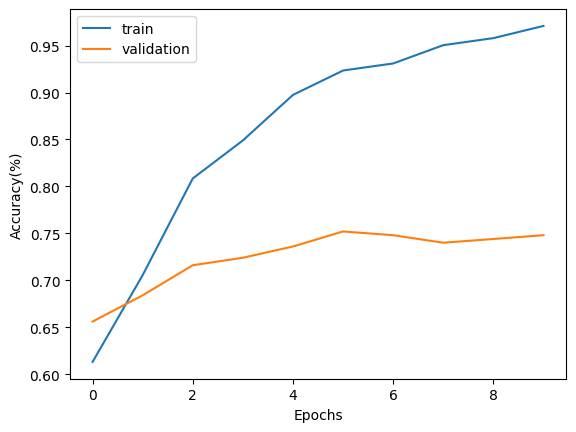

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend(['train', 'validation'])
plt.show()

In [53]:
model.evaluate(test_ds)

8/8 [==============================] - 2s 201ms/step - loss: 0.4810 - accuracy: 0.7760


[0.48099467158317566, 0.7760000228881836]

## Define Second Model

In [55]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [54]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype = tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid')(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [56]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [57]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 10)

Epoch 1/10
63/63 [==============================] - 1064s 17s/step - loss: 0.6849 - accuracy: 0.5780 - val_loss: 0.6618 - val_accuracy: 0.6280
Epoch 2/10
63/63 [==============================] - 1052s 17s/step - loss: 0.6674 - accuracy: 0.6030 - val_loss: 0.6514 - val_accuracy: 0.6400
Epoch 3/10
63/63 [==============================] - 1079s 17s/step - loss: 0.6434 - accuracy: 0.6210 - val_loss: 0.6537 - val_accuracy: 0.6160
Epoch 4/10
63/63 [==============================] - 1082s 17s/step - loss: 0.6388 - accuracy: 0.6300 - val_loss: 0.6332 - val_accuracy: 0.6360
Epoch 5/10
63/63 [==============================] - 1062s 17s/step - loss: 0.6226 - accuracy: 0.6665 - val_loss: 0.6354 - val_accuracy: 0.6200
Epoch 6/10
63/63 [==============================] - 1056s 17s/step - loss: 0.6174 - accuracy: 0.6670 - val_loss: 0.6147 - val_accuracy: 0.6840
Epoch 7/10
63/63 [==============================] - 1053s 17s/step - loss: 0.6056 - accuracy: 0.6910 - val_loss: 0.6201 - val_accuracy: 0.7000

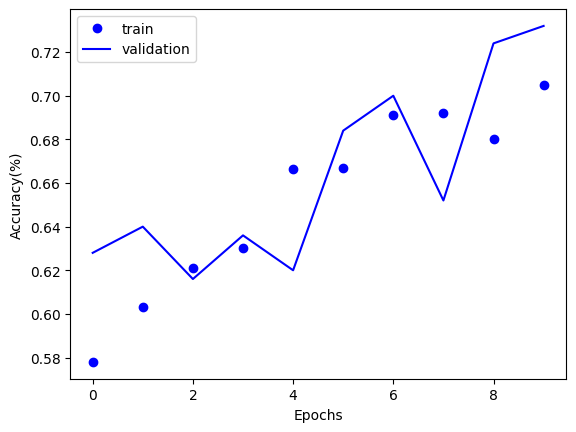

In [58]:
plt.plot(history.history['accuracy'], 'bo')
plt.plot(history.history['val_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend(['train', 'validation'])
plt.show()